# Scaling and Normalization
    Making Features Comparable Without Distorting Signal

## Objective

This notebook provides a systematic treatment of feature scaling, covering:

- When scaling is required (and when it is not)

- Standardization vs normalization

- Robust scaling under outliers

- Log and power transformations

- Scaling inside pipelines (leakage-safe)

It answers:

    How do we scale numeric features to support model learning without corrupting business signal?

## Why Scaling Matters

Incorrect scaling can:

- Bias distance-based models

- Slow or prevent convergence

- Inflate the influence of outliers

- Break regularization assumptions

Scaling is model-dependent, not universal.

## Imports and Dataset## 

This notebook demonstrates scaling and normalization techniques in a leakage-safe, production-aligned way.

## Imports

In [2]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PowerTransformer,
    FunctionTransformer
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


## Load Synthetic Dataset

In [4]:

df = pd.read_csv("../datasets/synthetic_customer_churn_classification_complete.csv")
df.head()


,customer_id,age,income,tenure_years,avg_monthly_usage,support_tickets_last_year,satisfaction_level,customer_segment,region,churn,future_retention_offer
0,1,18,NaN,2.012501,138.021163,1,NaN,segment_18,South,0,-0.069047
1,2,18,58991.061162,9.005550,213.043003,2,Very High,segment_98,West,0,-0.226607
2,3,67,31130.298545,3.633058,68.591582,2,Medium,segment_134,North,0,-0.065741
3,4,64,NaN,4.295957,28.790894,1,NaN,segment_72,North,0,0.061886
4,5,37,22301.231175,2.549855,100.136569,2,High,segment_147,East,1,1.073678


## Identify Numeric Features

In [5]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

Exclude target and identifiers:

In [6]:
numeric_features.remove("churn")
numeric_features.remove("customer_id")
numeric_features

['age',
 'income',
 'tenure_years',
 'avg_monthly_usage',
 'support_tickets_last_year',
 'future_retention_offer']

## Distribution Diagnostics

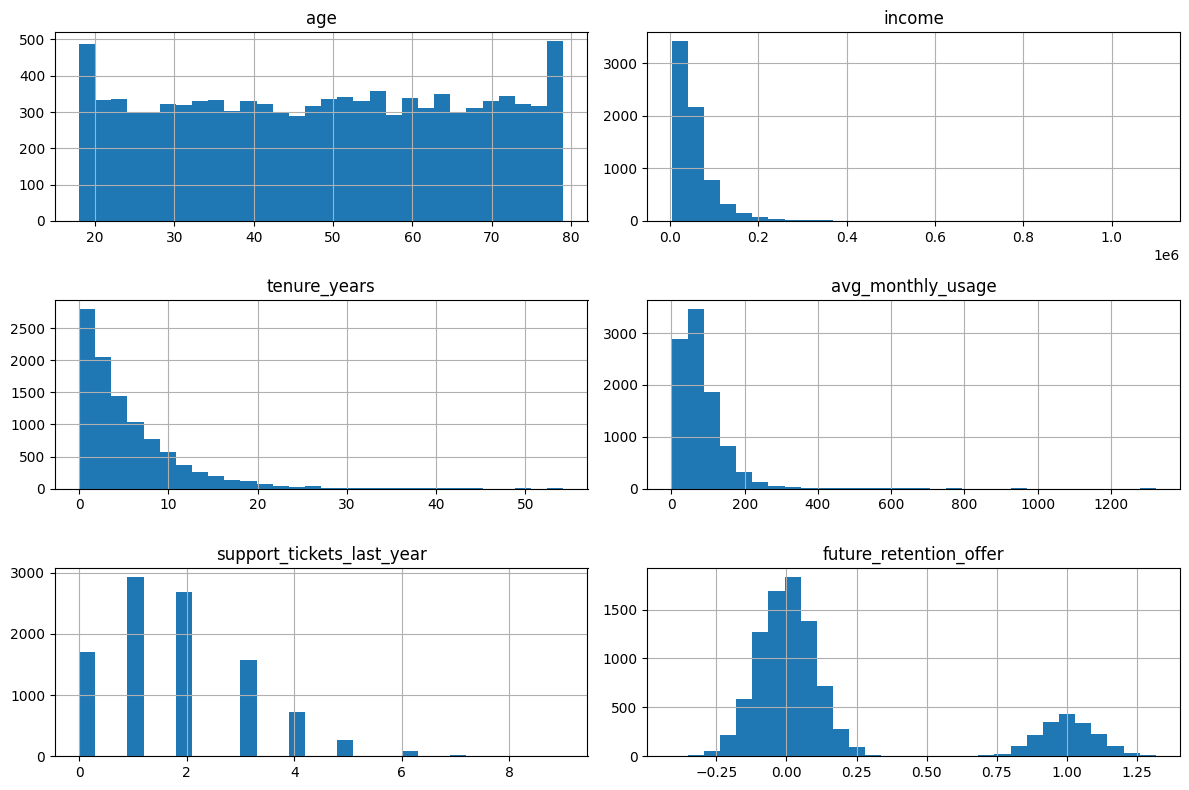

In [7]:

df[numeric_features].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()


# Standardization (Z-Score Scaling)
When to Use

- Linear models

- Regularized models

- PCA, SVM, KNNStandardScaler

In [15]:

standard_scaler = StandardScaler()
standard_scaled = standard_scaler.fit_transform(df[numeric_features])

pd.DataFrame(standard_scaled, columns=numeric_features).describe()


,age,income,tenure_years,avg_monthly_usage,support_tickets_last_year,future_retention_offer
count,1.000000e+04,7.000000e+03,10000.000000,9.600000e+03,1.000000e+04,1.000000e+04
mean,8.881784e-17,-9.846092e-17,0.000000,-1.554312e-17,1.065814e-17,6.430412e-17
std,1.000050e+00,1.000071e+00,1.000050,1.000052e+00,1.000050e+00,1.000050e+00
min,-1.708650e+00,-9.330995e-01,-1.001182,-1.207204e+00,-1.328278e+00,-1.483871e+00
25%,-8.716538e-01,-5.562576e-01,-0.706428,-6.151638e-01,-5.886610e-01,-5.901458e-01
50%,2.114253e-02,-2.624423e-01,-0.304728,-2.124220e-01,1.509558e-01,-3.900754e-01
75%,8.581391e-01,2.246591e-01,0.389743,3.618062e-01,8.905726e-01,-1.178015e-01
max,1.695136e+00,1.877325e+01,8.977577,1.867462e+01,5.328273e+00,2.820630e+00


- [neg] - Sensitive to outliers
- [pos] - Centers and scales variance

# – Min-Max Normalization
When to Use

- Neural networks

- Bounded feature assumptions

In [14]:

minmax_scaler = MinMaxScaler()
minmax_scaled = minmax_scaler.fit_transform(df[numeric_features])


minmax_scaled

array([[0.        ,        nan, 0.03709292, 0.10412231, 0.11111111,
        0.19742422],
       [0.        , 0.05075574, 0.16602598, 0.16084255, 0.22222222,
        0.10628103],
       [0.80327869, 0.0253523 , 0.06697165, 0.05163009, 0.22222222,
        0.19933675],
       ...,
       [0.70491803, 0.09036648, 0.05357535,        nan, 0.22222222,
        0.25701308],
       [0.06557377,        nan, 0.07746697, 0.04802522, 0.11111111,
        0.17172007],
       [0.55737705, 0.02992768, 0.07526372, 0.05772094, 0.33333333,
        0.78149652]])

- [pos] - Bounded [0, 1]
- [neg] - Compresses central mass when outliers exist

# Robust Scaling (Recommended Default)
When to Use

- Skewed distributions

- Outliers present

In [13]:

robust_scaler = RobustScaler()
robust_scaled = robust_scaler.fit_transform(df[numeric_features])


robust_scaled

array([[-1.        ,         nan, -0.29768412,  1.10070904, -0.5       ,
        -0.51653534],
       [-1.        ,  0.42200823,  0.87603085,  2.25499422,  0.        ,
        -1.34712857],
       [ 0.58064516, -0.2190448 , -0.0256894 ,  0.03246628,  0.        ,
        -0.49910641],
       ...,
       [ 0.38709677,  1.42158103, -0.14763977,         nan,  0.        ,
         0.02650133],
       [-0.87096774,         nan,  0.06985254, -0.04089457, -0.5       ,
        -0.75077879],
       [ 0.09677419, -0.1035857 ,  0.04979566,  0.15641805,  0.5       ,
         4.80614952]])

- [pos] - Resistant to outliers
- [pos] -  Stable under heavy tails

# Log Transformation

When to Use

- Positive-only variables

- Income, spend, usage

In [24]:

log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")
log_transformed = log_transformer.fit_transform(df[numeric_features])

log_transformed

,age,income,tenure_years,avg_monthly_usage,support_tickets_last_year,future_retention_offer
0,2.944439,NaN,1.102771,4.934626,0.693147,-0.071547
1,2.944439,10.985158,2.303140,5.366177,1.098612,-0.256968
2,4.219508,10.345969,1.533217,4.242644,1.098612,-0.068001
3,4.174387,NaN,1.666944,3.394203,0.693147,0.060046
4,3.637586,10.012442,1.266907,4.616472,1.098612,0.729324
...,...,...,...,...,...,...
9995,4.330733,10.996227,0.553041,NaN,0.000000,0.068832
9996,4.077537,12.014785,0.250492,3.452297,0.693147,-0.141834
9997,4.127134,11.536978,1.362635,NaN,1.098612,0.033400
9998,3.135494,NaN,1.649101,4.171669,0.693147,-0.120454


- [pos] - Reduces skew
- [neg] - Not applicable to zeros / negatives without adjustment

# Power Transformation 
## Yeo–Johnson (Handles Zero/Negative)

In [12]:

pt_yeo = PowerTransformer(method="yeo-johnson")
pt_yeo_scaled = pt_yeo.fit_transform(df[numeric_features])


pt_yeo_scaled

array([[-1.81053495,         nan, -0.56810122,  1.07978347, -0.47931048,
        -0.75931006],
       [-1.81053495,  0.49825924,  0.94852319,  1.78186719,  0.31275497,
        -2.35963991],
       [ 1.01729924, -0.34857783, -0.01627023,  0.06618312,  0.31275497,
        -0.73363965],
       ...,
       [ 0.70722983,  1.20513319, -0.23387665,         nan,  0.31275497,
        -0.08296031],
       [-1.54161035,         nan,  0.13075611, -0.03053118, -0.47931048,
        -1.13312521],
       [ 0.22858173, -0.14783748,  0.10132445,  0.21799772,  0.93927047,
         1.66258503]])

- [pos] - Gaussian-like distributions
- [pos] - Stable for ML algorithms

## Box–Cox (Positive Only)

In [17]:
pt_box = PowerTransformer(method="box-cox")

positive_only = df[numeric_features].clip(lower=1e-6)
box_scaled = pt_box.fit_transform(positive_only)

box_scaled

array([[-1.81397185,         nan, -0.5167409 ,  1.07678149, -0.06066672,
        -1.16358903],
       [-1.81397185,  0.49825485,  0.89939376,  1.78639259,  0.43184877,
        -1.16358903],
       [ 1.0169536 , -0.34857573, -0.02343839,  0.06275993,  0.43184877,
        -1.16358903],
       ...,
       [ 0.70753115,  1.20512894, -0.21876127,         nan,  0.43184877,
         0.4981377 ],
       [-1.54323076,         nan,  0.11023789, -0.0334184 , -0.06066672,
        -1.16358903],
       [ 0.22959808, -0.1478372 ,  0.08333927,  0.21391652,  0.77439541,
         1.22762245]])

# Visual Comparison (Example Feature)

In [20]:
robust_scaled[:, numeric_features.index(feature)]

array([        nan,  0.42200823, -0.2190448 , ...,  1.42158103,
               nan, -0.1035857 ])

In [22]:
numeric_features.index(feature)

1

In [25]:
log_transformed[feature]

0             NaN
1       10.985158
2       10.345969
3             NaN
4       10.012442
          ...    
9995    10.996227
9996    12.014785
9997    11.536978
9998          NaN
9999    10.495412
Name: income, Length: 10000, dtype: float64

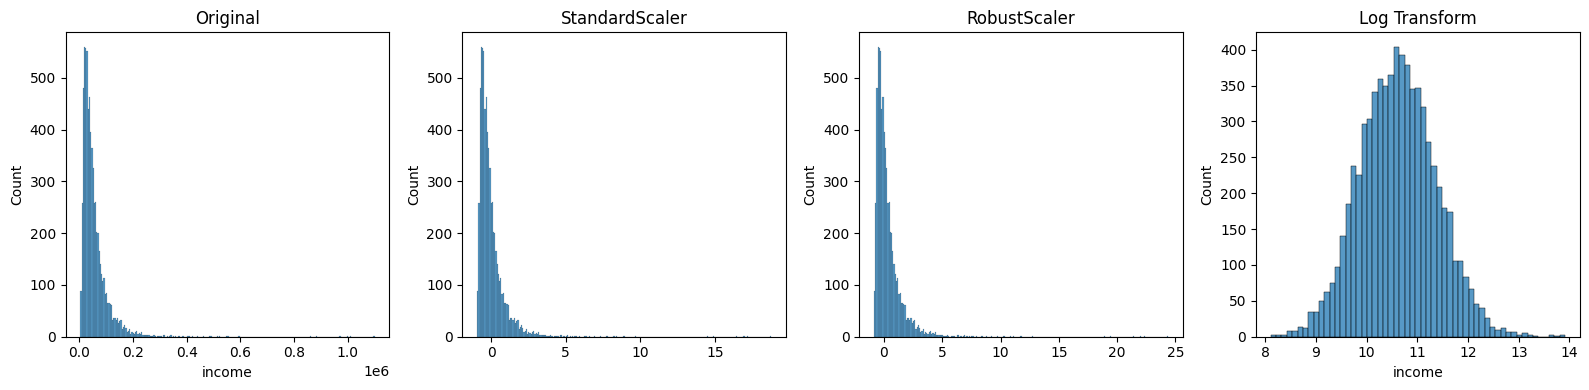

In [26]:
feature = "income"

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.histplot(df[feature], ax=axes[0])
axes[0].set_title("Original")

sns.histplot(standard_scaled[:, numeric_features.index(feature)], ax=axes[1])
axes[1].set_title("StandardScaler")

sns.histplot(robust_scaled[:, numeric_features.index(feature)], ax=axes[2])
axes[2].set_title("RobustScaler")

sns.histplot(log_transformed[feature], ax=axes[3])
axes[3].set_title("Log Transform")

plt.tight_layout()
plt.show()


# Step 9 – Scaling by Model Type




| Model             | Scaling Needed |
| ----------------- | -------------- |
| Linear / Logistic | Yes            |
| KNN / SVM         | Yes            |
| Neural Networks   | Yes            |
| Tree-Based        | Not required   |
| Random Forest     | Optional       |
| XGBoost           | Optional       |


# Scaling Inside Pipelines (Best Practice)

In [29]:

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", RobustScaler())
])

numeric_pipeline


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('log',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<ufunc 'log1p'>)),
                ('scaler', RobustScaler())])

- `[pos]` - Prevents leakage
- `[pos]` -  Ensures reproducibility
- `[pos]` -  Deployment-safe

# Step 11 – Common Mistakes (Avoided)

- `[avoid]` -  Scaling before train/test split

- `[avoid]` -  Applying StandardScaler blindly

- `[avoid]` -  Scaling tree-only pipelines unnecessarily

- `[avoid]` -  Ignoring skewness

- `[avoid]` -  Scaling categorical encodings improperly

# Summary Table


| Method         | Use Case            |
| -------------- | ------------------- |
| StandardScaler | Linear, SVM         |
| MinMaxScaler   | Neural networks     |
| RobustScaler   | Outliers present    |
| Log transform  | Skewed positives    |
| Yeo–Johnson    | Mixed distributions |
| Box–Cox        | Positive-only       |


## Key Takeaways
- Scaling is model-dependent
- RobustScaler handles outliers best
- Always scale inside pipelines to avoid leakage